In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

In [ ]:
train_df.head()

In [ ]:
train_df.tail()

**Missing value** Define a function that will find the missing values and plot the frequency of them. With this information we can impute the values accordingly or delete it (in the case of Cabin feature)

In [ ]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    fig=sns.barplot(ms.index, ms["Percent"],color="blue",alpha=0.8)
    plt.xlabel('Independent variables', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('NaN exploration', fontsize=15)
    return ms

missing_data(train_df)

In [ ]:
missing_data(test_df)

**Data imputation**

In [ ]:
test_df['Age'].fillna(test_df['Age'].median(),inplace = True)
train_df['Age'].fillna(train_df['Age'].median(),inplace = True)

drop_column=['Cabin']
train_df.drop(drop_column,axis=1,inplace=True)
test_df.drop(drop_column,axis=1,inplace=True)

test_df['Fare'].fillna(test_df['Fare'].median(),inplace=True)

train_df['Embarked'].fillna(train_df['Embarked'].mode()[0],inplace=True)

print(train_df.isnull().sum())
print(test_df.isnull().sum())

**Feature Engineering**
Character column Name: Extract tiles like Mrs, Miss, Mr

In [ ]:
all_data = [train_df,test_df]

In [ ]:
import re
# extract the second word from every name and assign it to a new column

def title_parser(name):
    # Check wheter title exists, then return it, if not return ""
    title_search = re.search('([A-Za-z]+)\.',name)
    if title_search:
        return title_search.group(1)
    return ""
# Create new column Title
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(title_parser)
    
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'irrelevant')
    dataset['Title'] = dataset['Title'].replace('Mlle','Miss')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    dataset['Title'] = dataset['Title'].replace('Mme','Mrs')

Before proceeding let us have a look at how our variables interact with each other

In [ ]:
g = sns.pairplot(data = train_df, hue ='Survived',palette ='seismic',size=1.2, diag_kind='kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))
g.set(xticklabels=[])

In [ ]:
# create new feature FamilySize as a combination of SibSp and Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp']+dataset['Parch']+1
# create bin for age features
for dataset in all_data:
    dataset['Age_bin']= pd.cut(dataset['Age'],bins=[0,12,20,40,120],labels=['Children','Teenager','Adult','Elder'])

In [ ]:
#create bin for fare features
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'],bins=[0,7.91,14.45,31,120],labels=['Low_fare','median_fare','Average_fare','high_fare'])

In [ ]:
train_df.head()

In [ ]:
for dataset in all_data:
    drop_column =['Name','Ticket']
    dataset.drop(drop_column,axis=1,inplace=True)

In [ ]:
train_df.head()

**Hot encoding**

In [ ]:
train_df = pd.get_dummies(train_df,columns=['Sex','Embarked','Title','Age_bin','Fare_bin'],prefix=['Sex','Embarked','Title','Age_bin','Fare_bin'])
test_df = pd.get_dummies(test_df,columns=['Sex','Embarked','Title','Age_bin','Fare_bin'],prefix=['Sex','Embarked','Title','Age_bin','Fare_bin'])
train_df.head()

**Correlation between variables**

In [ ]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

**Scaling and data-transformation**

In [ ]:
from sklearn.preprocessing import MinMaxScaler

train_df[['Age','Fare']] = train_df[['Age','Fare']].apply(pd.to_numeric)
scaler = MinMaxScaler()
train_df[['Age','Fare']] = scaler.fit_transform(train_df[['Age','Fare']])

drop_column =['PassengerId']
train_df.drop(drop_column,axis=1,inplace=True)

train_X = train_df.drop('Survived',axis=1)
train_Y = train_df['Survived']

test_X = test_df.drop('PassengerId',axis=1).copy()

train_df.head()

**Modeling**

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10,random_state=22)

all_features = train_df.drop('Survived',axis=1)
targeted_feature = train_df['Survived']

X_train,X_test,y_train,y_test = train_test_split(all_features, targeted_feature,test_size=0.3,random_state=42)

**eXtreme Gradient Boosting**

In [35]:
train_X = train_df.drop('Survived',axis=1)
train_Y = train_df['Survived']
test_X = test_df.drop('PassengerId',axis=1).copy()

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
param_grid ={'loss':['deviance'],
            'n_estimators':[100,200,300,400],
            'learning_rate':[0.1,0.05,0.01,0.001],
            'max_depth':[4,8],
            'min_samples_leaf':[100,150],
             'max_features':[0.3,0.2,0.1]}

modelf = GridSearchCV(model,param_grid=param_grid,cv=kfold,scoring="accuracy",n_jobs=4,verbose=1)
modelf.fit(train_X,train_Y)

modelf.best_estimator_

Fitting 10 folds for each of 192 candidates, totalling 1920 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   35.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 1920 out of 1920 | elapsed:  2.4min finished


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=8,
                           max_features=0.3, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=100, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [36]:
modelf.best_score_

0.835016835016835

**Random Forest parameter tuning and other models:**

In [37]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
n_estim = range(100,1000,100)

param_grid ={'n_estimators':n_estim}

model_rf = GridSearchCV(model,param_grid = param_grid,cv=5,scoring="accuracy",n_jobs=4,verbose=1)

model_rf.fit(train_X,train_Y)

model_rf.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:   25.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
model_rf.best_score_

0.8080808080808081

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model = LinearDiscriminantAnalysis()
param_grid = {'tol':[0.001,0.01,0.1,0.2]}

modell = GridSearchCV(model,param_grid = param_grid,cv=5,scoring="accuracy",n_jobs=4,verbose=1)

modell.fit(train_X, train_Y)

modell.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.1s finished


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.001)

In [40]:
modell.best_score_

0.8249158249158249

**Logistic Regression**

Accuracy 83.21
The cross validated score  81.82


Text(0.5, 1.05, 'Confusion matrix')

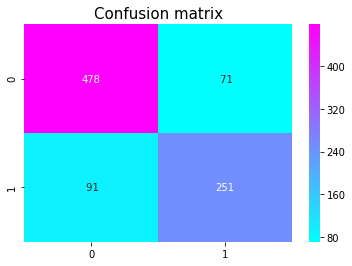

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression()
model.fit(X_train,y_train)
prediction_lr = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_lr,y_test)*100,2))

result_lr = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_lr.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)


Accuracy 83.58
The cross validated score  83.16


Text(0.5, 1.05, 'Confusion matrix')

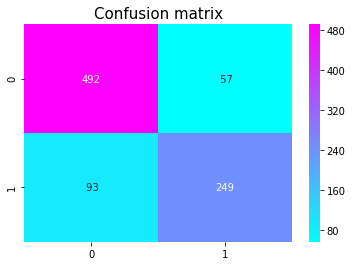

In [42]:
from sklearn.svm import SVC, LinearSVC

model = SVC()
model.fit(X_train,y_train)
prediction_svm = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_svm,y_test)*100,2))

result_svm = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_svm.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 80.97
The cross validated score  82.27


Text(0.5, 1.05, 'Confusion matrix')

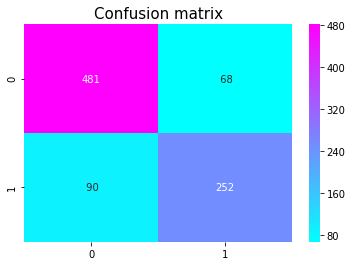

In [43]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train,y_train)
prediction_knn = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_knn,y_test)*100,2))

result_knn = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_knn.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 76.87
The cross validated score  79.02


Text(0.5, 1.05, 'Confusion matrix')

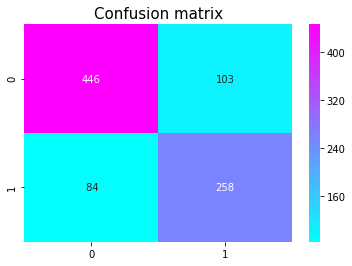

In [44]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train,y_train)
prediction_gnb = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_gnb,y_test)*100,2))

result_gnb = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_gnb.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 76.12
The cross validated score  81.26


Text(0.5, 1.05, 'Confusion matrix')

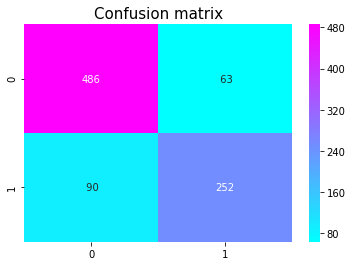

In [45]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='gini',
                              min_samples_split = 10,
                              min_samples_leaf = 1,
                              max_features ='auto')
model.fit(X_train,y_train)
prediction_tree = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_tree,y_test)*100,2))

result_tree = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_tree.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 80.97
The cross validated score  81.49


Text(0.5, 1.05, 'Confusion matrix')

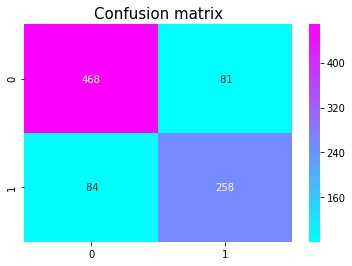

In [46]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train,y_train)
prediction_adb = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_adb,y_test)*100,2))

result_adb = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_adb.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 82.84
The cross validated score  82.72


Text(0.5, 1.05, 'Confusion matrix')

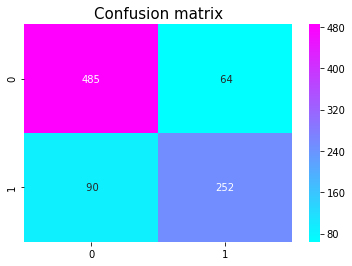

In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis()
model.fit(X_train,y_train)
prediction_lda = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_lda,y_test)*100,2))

result_lda = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_lda.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 82.09
The cross validated score  84.29


Text(0.5, 1.05, 'Confusion matrix')

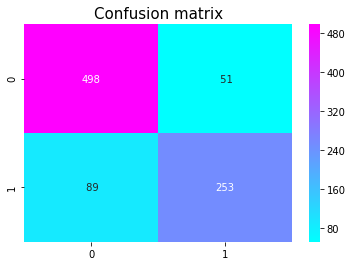

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train,y_train)
prediction_gbc = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_gbc,y_test)*100,2))

result_gbc = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_gbc.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 82.09
The cross validated score  84.29


Text(0.5, 1.05, 'Confusion matrix')

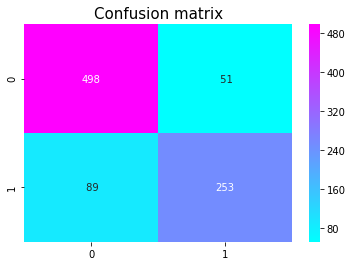

In [50]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(criterion='gini',n_estimators=700,
                                 min_samples_split = 10, min_samples_leaf=1,
                                 max_features='auto',oob_score=True,
                                 random_state=1,n_jobs=-1)
model_rf.fit(X_train,y_train)
prediction_rm = model.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_rm,y_test)*100,2))

result_rm = cross_val_score(model, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_rm.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

Accuracy 78.36
The cross validated score  80.7


Text(0.5, 1.05, 'Confusion matrix')

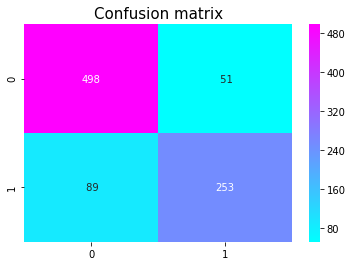

In [52]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(bootstrap = True, class_weight = None,
                                max_depth = None, max_leaf_nodes = None,
                                min_weight_fraction_leaf = 0.0,
                                 criterion='gini',n_estimators=100,
                                 min_samples_split = 2, min_samples_leaf=1,
                                 max_features='auto',oob_score=False,
                                 random_state=None,n_jobs=None,
                               verbose=0, warm_start = False)
model1.fit(X_train,y_train)
prediction_rm1 = model1.predict(X_test)

print('Accuracy',round(accuracy_score(prediction_rm1,y_test)*100,2))

result_rm1 = cross_val_score(model1, all_features, targeted_feature, cv=10,scoring='accuracy')
print('The cross validated score ',round(result_rm1.mean()*100,2))

y_pred = cross_val_predict(model,all_features, targeted_feature,cv=10)
sns.heatmap(confusion_matrix(targeted_feature,y_pred),annot=True,fmt='3.0f',cmap="cool")
plt.title('Confusion matrix',y=1.05,size=15)

In [53]:
models = pd.DataFrame({
    'Model':["support vector machine","KNN","Logistic Regression",
            "Random Forest","Naive Bayes","AdaBoostClassifier",
            "Gradient Decent","Linear Discriminant Analysis",
            "Decision Tree","Tuned RF"],
    "Score":[result_svm.mean(), result_knn.mean(),result_lr.mean(),
            result_rm.mean(),result_gnb.mean(),result_adb.mean(),
            result_gbc.mean(),result_lda.mean(),result_tree.mean(),
            result_rm1.mean()]
})
models.sort_values(by="Score",ascending=False)

,Model,Score
3,Random Forest,0.842892
6,Gradient Decent,0.842892
0,support vector machine,0.831644
7,Linear Discriminant Analysis,0.827175
1,KNN,0.822667
2,Logistic Regression,0.818249
5,AdaBoostClassifier,0.814877
8,Decision Tree,0.812606
9,Tuned RF,0.807013
4,Naive Bayes,0.790157


Now we use our best model to create ouput set

In [54]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(bootstrap = True, class_weight = None,
                                max_depth = None, max_leaf_nodes = None,
                                min_weight_fraction_leaf = 0.0,
                                 criterion='gini',n_estimators=100,
                                 min_samples_split = 2, min_samples_leaf=1,
                                 max_features='auto',oob_score=False,
                                 random_state=None,n_jobs=None,
                               verbose=0, warm_start = False)
random_forest.fit(train_X, train_Y)
Y_pred_rf = random_forest.predict(test_X)
random_forest.score(train_X,train_Y)
acc_random_forest = round(random_forest.score(train_X, train_Y)*100,2)
print(acc_random_forest)


98.2


Feature selection


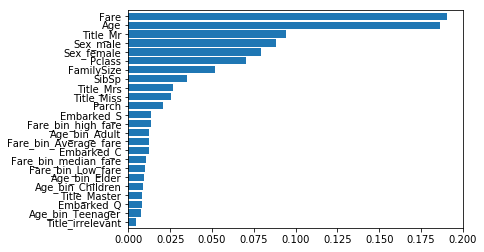

In [55]:
print("Feature selection")
pd.Series(random_forest.feature_importances_,X_train.columns).sort_values(ascending=True).plot.barh(width=0.8)

In [56]:
submission = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":Y_pred_rf
})

In [57]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [58]:
submission.to_csv('submission.csv',index=False)